In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline

import seaborn as sns
sns.set(style="whitegrid")

from PIL import Image
from sklearn.preprocessing import MinMaxScaler

In [2]:
np.random.seed(23)

In [3]:
h, v = np.meshgrid(np.arange(2), np.arange(2))
p1 = np.vstack([h.ravel(), v.ravel()]).T

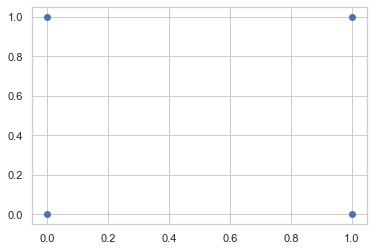

In [4]:
plt.scatter(*p1.T)

In [5]:
H = np.random.rand(3, 3)
H = H / H[2, 2]
H

array([[0.8369807 , 1.53217217, 1.23850312],
       [0.4569125 , 0.35764829, 1.11029768],
       [0.27042888, 0.63496639, 1.        ]])

In [6]:
def to_hom(points):
    ones = np.ones((points.shape[0], 1))
    hom = np.concatenate((points, ones), axis=1)
    return hom

In [7]:
p1h = to_hom(p1)

In [8]:
p2h = p1h @ H.T

In [9]:
p2h.shape

(4, 3)

In [10]:
p2 = (p2h / p2h[:, 2][:, None])[:, :2]

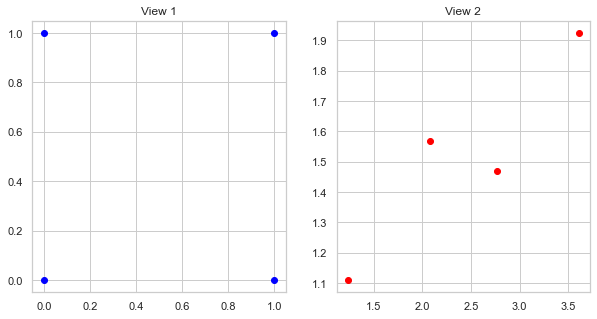

In [11]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(p1h[:, 0], p1h[:, 1], c='blue')
plt.title('View 1')
plt.subplot(1, 2, 2)
plt.scatter(p2h[:, 0], p2h[:, 1], c='red')
plt.title('View 2')
plt.show()

In [12]:
Hest, _ = cv2.findHomography(p1, p2)

In [13]:
H, Hest

(array([[0.8369807 , 1.53217217, 1.23850312],
        [0.4569125 , 0.35764829, 1.11029768],
        [0.27042888, 0.63496639, 1.        ]]),
 array([[0.83698064, 1.53217124, 1.2385031 ],
        [0.45691247, 0.35764781, 1.11029768],
        [0.27042885, 0.63496587, 1.        ]]))

In [14]:
def get_coefficient_matrix(pts1, pts2):
    num_points = pts1.shape[0]
    A = np.zeros((2 * num_points, 9))

    for i in range(num_points):
        x, y = pts1[i]
        u, v = pts2[i]

        A[2*i] = [-x, -y, -1, 0, 0, 0, u*x, u*y, u]
        A[2*i+1] = [0, 0, 0, -x, -y, -1, v*x, v*y, v]
        
    return A

In [15]:
A = get_coefficient_matrix(p1, p2)

In [16]:
def get_eigen_dec(A):
    cov = A.T @ A
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices].T
    
    return eigenvalues, eigenvectors

eigenvalues, eigenvectors = get_eigen_dec(A)

In [17]:
def get_h_estimate(eigenvectors):
    h = eigenvectors[8]
    h = h / h[8]
    
    return h

h = get_h_estimate(eigenvectors)

In [18]:
def get_J_hom(eigenvalues, eigenvectors):
    J = np.zeros((9, 9))
    for k in range(8):
        J += (eigenvectors[k].reshape(-1, 1) * eigenvectors[k].T.reshape(1, -1)) / eigenvalues[k]
    J *= -1
    
    return J

In [19]:
eigenvalues

array([3.26296097e+01, 6.43097243e+00, 4.88365328e+00, 2.70217897e+00,
       1.01387908e+00, 6.48685570e-01, 8.73962338e-03, 2.59468305e-03,
       5.50872205e-16])

In [20]:
J = get_J_hom(eigenvalues, eigenvectors)
J

array([[-114.32615266,   81.35859262,   -7.52244451,  -71.94740275,
          58.18265573,  -13.47755573,  -65.91013221,   51.56949055,
          -7.54206787],
       [  81.35859262, -114.08946283,   49.02166262,   49.59203571,
         -83.37787809,   45.90586589,   44.01641882,  -73.72652375,
          37.09775756],
       [  -7.52244451,   49.02166262,  -34.56618487,   -3.58397625,
          36.32833367,  -28.89000549,   -2.1529294 ,   32.12711674,
         -25.09928018],
       [ -71.94740275,   49.59203571,   -3.58397625,  -46.74446891,
          35.41528186,   -6.79064318,  -41.95399057,   31.38260248,
          -3.67595824],
       [  58.18265573,  -83.37787809,   36.32833367,   35.41528186,
         -62.35583233,   34.63993876,   31.37980461,  -54.29907989,
          27.7099632 ],
       [ -13.47755573,   45.90586589,  -28.89000549,   -6.79064318,
          34.63993876,  -25.8222654 ,   -5.7378383 ,   30.22516924,
         -21.53094721],
       [ -65.91013221,   44.01641882,   

In [21]:
h

array([0.8369807 , 1.53217217, 1.23850312, 0.4569125 , 0.35764829,
       1.11029768, 0.27042888, 0.63496639, 1.        ])

In [22]:
def get_fio(h, x, y, X, sigma_pt, sigma_w):
    sigma_pt = sigma_pt**2
    sigwa_w = sigma_w.T @ sigma_w
    
    ft = sigma_pt * (h[0]**2 + h[1]**2 - 2 * X * (h[0] * h[6] + h[1] * h[7]))
    st = (2 * sigma_w) * (x * h[6] * h[8] + x * y * h[6] * h[7] + y * h[7] * h[8])
    tt = (sigma_pt * X**2 + x**2 * sigwa_w) * h[6]**2
    kt = (sigma_pt * X**2 + y**2 * sigwa_w) * h[7]**2
    jt = sigma_w * h[8]**2
    
    return ft + st + tt + kt + jt

def get_fie(h, x, y, Y, sigma_pt, sigma_w):
    sigma_pt = sigma_pt**2
    sigwa_w = sigma_w.T @ sigma_w
    
    ft = sigma_pt * (h[3]**2 + h[4]**2 - 2 * Y * (h[3] * h[6] + h[5] * h[7]))
    st = (2 * sigma_w) * (x * h[6] * h[8] + x * y * h[6] * h[7] + y * h[7] * h[8])
    tt = (sigma_pt * Y**2 + x**2 * sigwa_w) * h[6]**2
    kt = (sigma_pt * Y**2 + y**2 * sigwa_w) * h[7]**2
    jt = sigma_w * h[8]**2
    
    return ft + st + tt + kt + jt

def get_fioe(h, X, Y, sigma_pt):
    sigma_pt = sigma_pt**2
    ft = (h[0] - X * h[6]) * (h[3] - Y * h[6])
    st = (h[1] - X * h[7]) * (h[4] - Y * h[7])
    
    return sigma_pt * (ft + st)

def get_S(A, h, p1, p2, sigma_pt, sigma_W):
    '''
    A: [9, 9]
    '''
    
    n = 9
    
    S = np.zeros((9, 9))
    for i in range(1, 5):
        x1 = p1[i - 1]
        x2 = p2[i - 1]
        x, y = x1
        X, Y = x2
        
        fio = get_fio(h, x, y, X, sigma_pt, sigma_W)
        fie = get_fie(h, x, y, Y, sigma_pt, sigma_W)
        fioe = get_fioe(h, X, Y, sigma_pt)
        
        a1 = A[2*i - 2][None]
        ft = a1.T @ a1 * fio
        
        a2 = A[2*i - 1][None]
        st = a2.T @ a2 * fie
        
        tt = a1.T @ a2 * fioe
        kt = a2.T @ a1 * fioe

        S += (ft + st + tt + kt)
        
    return S

In [23]:
S = get_S(A, h, p1, p2, np.eye(1), np.eye(1))
assert S.shape == (9, 9)

In [24]:
def get_hom_cov(p1, p2, sigma_pts = np.eye(1), sigma_w = np.eye(1)):
    A = get_coefficient_matrix(p1, p2)
    eigenvalues, eigenvectors = get_eigen_dec(A)
    
    h = get_h_estimate(eigenvectors)
    J_hom = get_J_hom(eigenvalues, eigenvectors)
    S = get_S(A, h, p1, p2, sigma_pts, sigma_w)
    
    hom_cov = J @ S @ J
    
    return h, hom_cov

In [25]:
h, hom_cov = get_hom_cov(p1, p2)
h, hom_cov

(array([0.8369807 , 1.53217217, 1.23850312, 0.4569125 , 0.35764829,
        1.11029768, 0.27042888, 0.63496639, 1.        ]),
 array([[168.54940339, -93.07876377,  -9.34016209, 117.04010376,
         -61.5797192 ,  -3.84367293,  98.80053731, -57.72428744,
          -4.14320655],
        [-93.07876377, 179.63635754, -94.24202313, -61.49727112,
         129.27706482, -80.10394641, -44.55273503, 117.37718175,
         -72.28950124],
        [ -9.34016209, -94.24202313,  77.80780759,  -8.80074965,
         -70.48173379,  63.73442058, -13.09388757, -63.05570415,
          57.89121059],
        [117.04010376, -61.49727112,  -8.80074965,  83.47540548,
         -40.47016852,  -5.47906104,  70.06217242, -37.90663481,
          -5.29702138],
        [-61.5797192 , 129.27706482, -70.48173379, -40.47016852,
          95.80336534, -60.51747059, -28.51143378,  85.71713541,
         -54.53919851],
        [ -3.84367293, -80.10394641,  63.73442058,  -5.47906104,
         -60.51747059,  53.60156104,  -

In [26]:
def get_B(x_hom):
    B = np.zeros((3, 9))
    B[0, :3] = x_hom
    B[1, 3:6] = x_hom
    B[2, 6:] = x_hom
    
    return B

def get_J_hom_to_pixel(ph):
    J = np.zeros((2, 3))
    J[0, 0] = ph[2]
    J[0, 2] = -ph[0]
    J[1, 1] = ph[2]
    J[1, 2] = -ph[1]
    
    J = J / (ph[2]**2)
    
    return J

In [27]:
def get_trans(p1, p2):
    p1h = to_hom(p1)
    p1h /= np.linalg.norm(p1h)

    h, hom_cov = get_hom_cov(p1, p2, T, T_prime)
    Hest = h.reshape((3, 3))
    
    covs = []
    for i in range(4):
        B = get_B(p1h[i])
        uncertain_H_exact_x = B @ hom_cov @ B.T
        
        Ux = np.ones((3, 3))
        Ux[2, 2] = 0
        uncertain_x_exact_H = Hest @ Ux @ Hest.T
        
        Sigma = uncertain_H_exact_x + uncertain_x_exact_H
    
        
        cov = get_J_hom_to_pixel(p1h[idx]) @ Sigma @ get_J_hom_to_pixel(p1h[idx]).T
        covs.append(cov)
        
    return Hest, covs

In [28]:
def get_J_hom_to_pixel(ph):
    J = np.zeros((2, 3))
    J[0, 0] = ph[2]
    J[0, 2] = -ph[0]
    J[1, 1] = ph[2]
    J[1, 2] = -ph[1]
    
    J = J / (ph[2]**2)
    
    return J

In [29]:
def plot_ellipse(mean, covariance, ax, color = 'r', linestyle="-"):
    eigenvalues, eigenvectors = np.linalg.eig(covariance)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    ellipse = Ellipse(mean, 2 * np.sqrt(2 * eigenvalues[0]), 2 * np.sqrt(2 * eigenvalues[1]),
                      angle=angle, facecolor='none',
                      edgecolor=color, linestyle=linestyle, 
                      linewidth=3
    )
    ax.add_patch(ellipse)

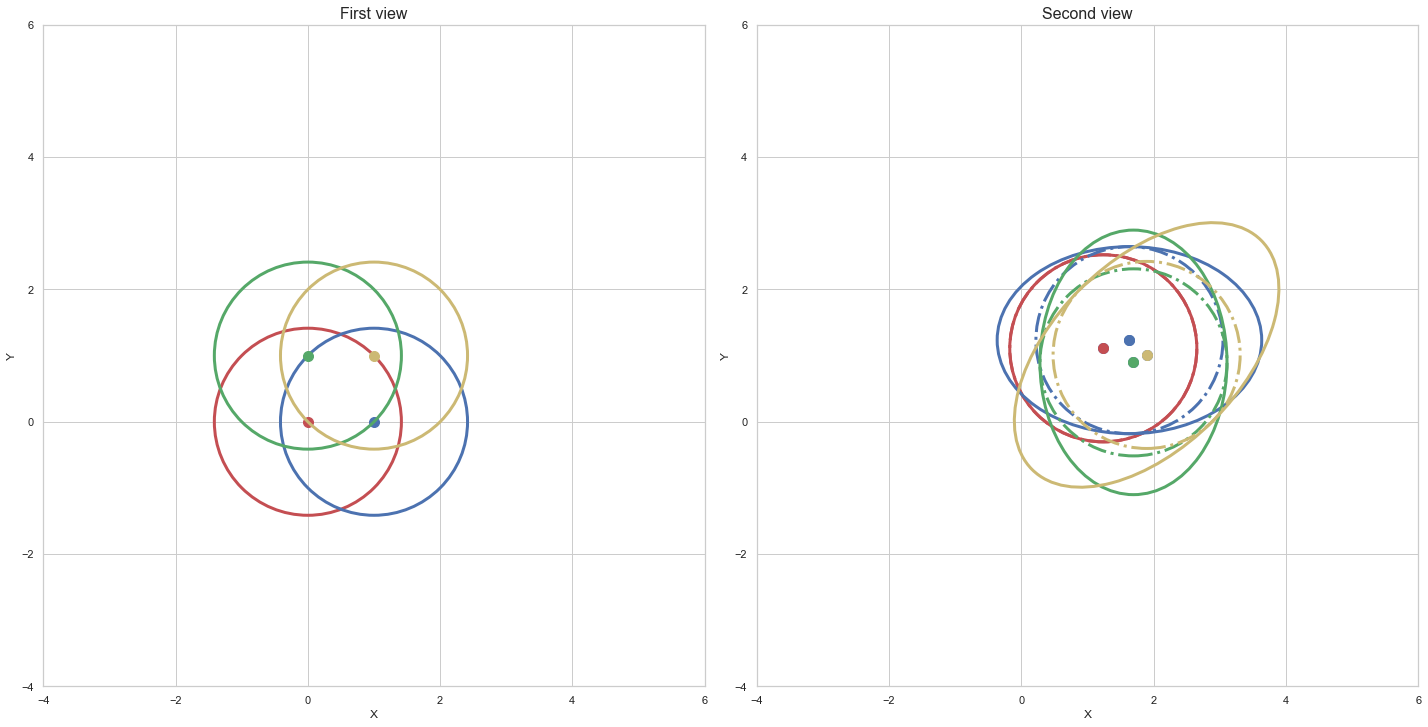

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

COLORS = ["r", "b", "g", "y"]

# Subplot 1
for idx, point in enumerate(p1):
    plot_ellipse(point, np.eye(2), ax[0], color=COLORS[idx])
    ax[0].scatter(*point, c=COLORS[idx], marker='o', s=100)

# Subplot 2
ax[1].scatter(*np.array(p2).T, c='b', marker='o', s=100)
for idx, point in enumerate(p2):
    plot_ellipse(point, np.eye(2), ax[1], color=COLORS[idx], linestyle="-.")

    
    # point to H
    uHest = np.eye(3)  # Example transformation matrix
    up = get_J_hom_to_pixel(p1h[idx]) @ uHest @ get_J_hom_to_pixel(p1h[idx]).T
    
    plot_ellipse(point, up, ax[1], color=COLORS[idx], linestyle="-")
    ax[1].scatter(*point, c=COLORS[idx], marker='o', s=100)

# Customize plot appearance
ax[0].set_aspect('equal')
ax[0].set_title('First view', fontsize=16)
ax[0].set_xlabel('X', fontsize=12)
ax[0].set_ylabel('Y', fontsize=12)
ax[0].grid(True)
ax[0].set_xlim([-4, 6])
ax[0].set_ylim([-4, 6])

ax[1].set_aspect('equal')
ax[1].set_title('Second view', fontsize=16)
ax[1].set_xlabel('X', fontsize=12)
ax[1].set_ylabel('Y', fontsize=12)
ax[1].grid(True)
ax[1].set_xlim([-4, 6])
ax[1].set_ylim([-4, 6])

plt.tight_layout()
plt.show()

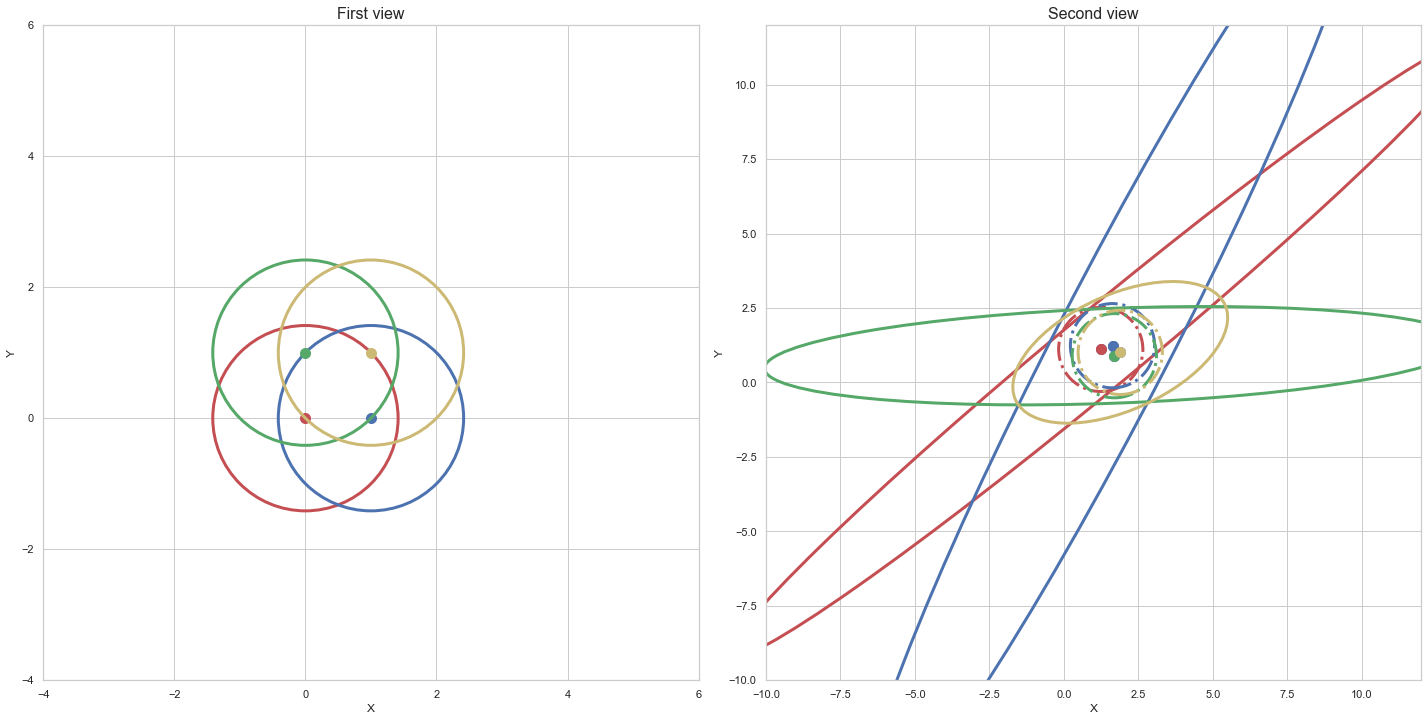

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

COLORS = ["r", "b", "g", "y"]

# Subplot 1
for idx, point in enumerate(p1):
    plot_ellipse(point, np.eye(2), ax[0], color=COLORS[idx])
    ax[0].scatter(*point, c=COLORS[idx], marker='o', s=100)

# Subplot 2
ax[1].scatter(*np.array(p2).T, c='b', marker='o', s=100)
for idx, point in enumerate(p2):
    plot_ellipse(point, np.eye(2), ax[1], color=COLORS[idx], linestyle="-.")
    
    B = get_B(p1h[idx])
    uncertain_H_exact_x = B @ hom_cov @ B.T
    uncertain_H_exact_x = get_J_hom_to_pixel(p1h[idx]) @ uncertain_H_exact_x @ get_J_hom_to_pixel(p1h[idx]).T
    
    cov = uncertain_H_exact_x
    
    plot_ellipse(point, cov, ax[1], color=COLORS[idx], linestyle="-")
    ax[1].scatter(*point, c=COLORS[idx], marker='o', s=100)

# Customize plot appearance
ax[0].set_aspect('equal')
ax[0].set_title('First view', fontsize=16)
ax[0].set_xlabel('X', fontsize=12)
ax[0].set_ylabel('Y', fontsize=12)
ax[0].grid(True)
ax[0].set_xlim([-4, 6])
ax[0].set_ylim([-4, 6])

ax[1].set_aspect('equal')
ax[1].set_title('Second view', fontsize=16)
ax[1].set_xlabel('X', fontsize=12)
ax[1].set_ylabel('Y', fontsize=12)
ax[1].grid(True)
ax[1].set_xlim([-10, 12])
ax[1].set_ylim([-10, 12])

plt.tight_layout()
plt.show()

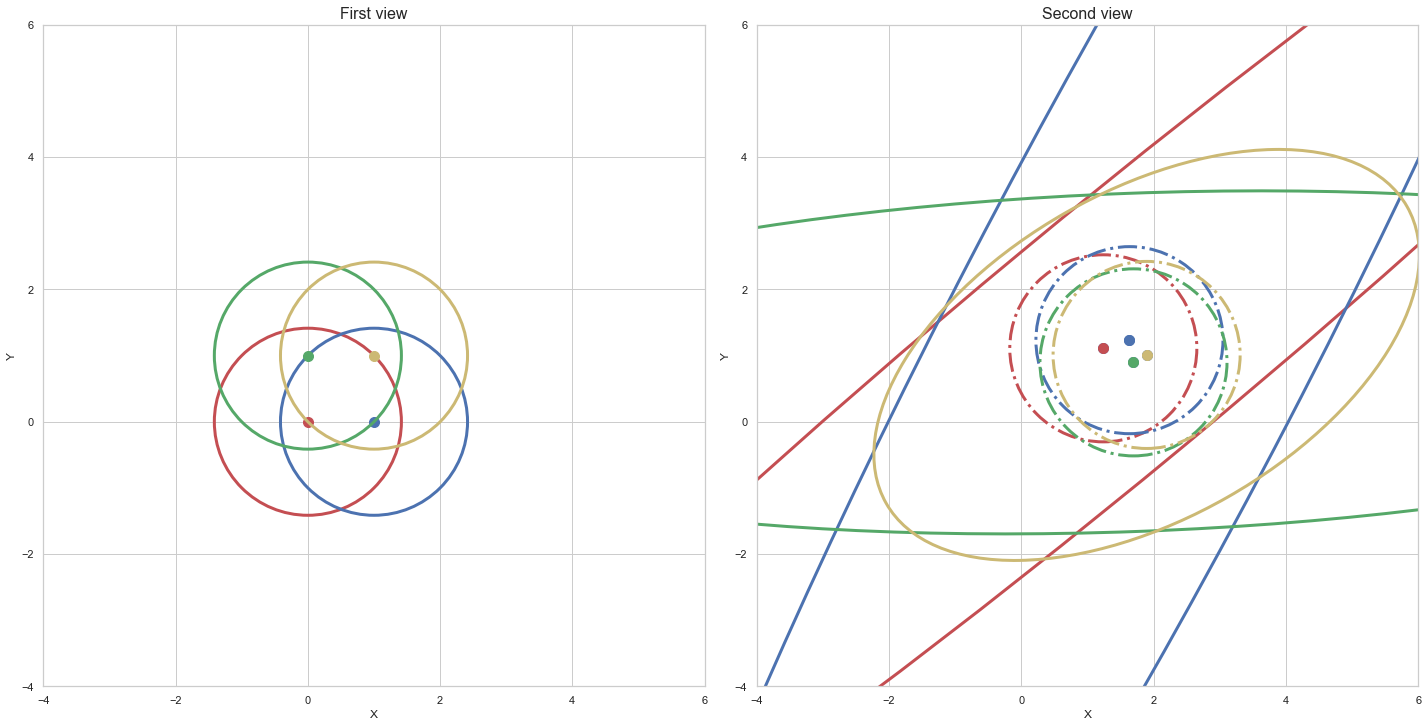

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

COLORS = ["r", "b", "g", "y"]

# Subplot 1
for idx, point in enumerate(p1):
    plot_ellipse(point, np.eye(2), ax[0], color=COLORS[idx])
    ax[0].scatter(*point, c=COLORS[idx], marker='o', s=100)

# Subplot 2
ax[1].scatter(*np.array(p2).T, c='b', marker='o', s=100)
for idx, point in enumerate(p2):
    plot_ellipse(point, np.eye(2), ax[1], color=COLORS[idx], linestyle="-.")
    
    B = get_B(p1h[idx])
    uncertain_H_exact_x = B @ hom_cov @ B.T
    uncertain_H_exact_x = get_J_hom_to_pixel(p1h[idx]) @ uncertain_H_exact_x @ get_J_hom_to_pixel(p1h[idx]).T

    uHest = np.eye(3) 
    uncertain_x_exact_H = get_J_hom_to_pixel(p1h[idx]) @ uHest @ get_J_hom_to_pixel(p1h[idx]).T
    
    cov = uncertain_H_exact_x + uncertain_x_exact_H
    
    plot_ellipse(point, cov, ax[1], color=COLORS[idx], linestyle="-")
    ax[1].scatter(*point, c=COLORS[idx], marker='o', s=100)

# Customize plot appearance
ax[0].set_aspect('equal')
ax[0].set_title('First view', fontsize=16)
ax[0].set_xlabel('X', fontsize=12)
ax[0].set_ylabel('Y', fontsize=12)
ax[0].grid(True)
ax[0].set_xlim([-4, 6])
ax[0].set_ylim([-4, 6])

ax[1].set_aspect('equal')
ax[1].set_title('Second view', fontsize=16)
ax[1].set_xlabel('X', fontsize=12)
ax[1].set_ylabel('Y', fontsize=12)
ax[1].grid(True)
ax[1].set_xlim([-4, 6])
ax[1].set_ylim([-4, 6])

plt.tight_layout()
plt.show()